<a href="https://colab.research.google.com/github/sharathreddym/CCPS_NLP/blob/master/xgboost_prodmatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar 29 04:35:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!pip install jellyfish
!pip install fuzzywuzzy

In [5]:
import time
import re
import pandas as pd
import numpy as np
import jellyfish as jf
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:
import nltk
from nltk import word_tokenize

In [7]:
downloaded = drive.CreateFile({'id':"1rxFikuKTd984aoAkRlFEGPkGfIFXv6DN"}) 
downloaded.GetContentFile('cp1252.csv')
cpf = pd.read_csv('cp1252.csv')

In [8]:
# https://drive.google.com/file/d/1_EVQaRhoHEwW9YRlLTjF2K1MEqnyOm7v/view?usp=sharing

In [9]:
downloaded = drive.CreateFile({'id':"1_EVQaRhoHEwW9YRlLTjF2K1MEqnyOm7v"}) 
downloaded.GetContentFile('matches_training.csv')
mdf = pd.read_csv('matches_training.csv')

In [10]:
# https://drive.google.com/file/d/1lcbULQrvnvWzUDD39-62aL-pEIr7XwYw/view?usp=sharing

In [107]:
downloaded = drive.CreateFile({'id':"1lcbULQrvnvWzUDD39-62aL-pEIr7XwYw"}) 
downloaded.GetContentFile('offers_training.csv')
df = pd.read_csv('offers_training.csv')

In [12]:
# https://drive.google.com/file/d/19QRM6rfXVtyidPxIZzIvn7BRxz94P7ZZ/view?usp=sharing

In [13]:
downloaded = drive.CreateFile({'id':"19QRM6rfXVtyidPxIZzIvn7BRxz94P7ZZ"}) 
downloaded.GetContentFile('offers_test.csv')
tdf = pd.read_csv('offers_test.csv')

In [108]:
cpfl = cpf['mappings'].values.tolist()

cpfl2 = []
for i in cpfl:
    cpfl2.append([i, ""])
    
dcp = dict(cpfl2)

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

# replace_all(tst, dcp)

In [109]:
df['splitcolor'] = df['color'].apply(lambda x : str(x).lower().split("|"))
df['clean_desc'] = df['description'].apply(lambda x : replace_all(x, dcp))
compdf = df[df['shop']=="aboutyou"]
zaldf = df[df['shop']=="zalando"]
zaldf['clean_desc1'] = zaldf['clean_desc'].apply(lambda x : [i.lower() for i in x.split("$")])
zaldf['clean_desc2'] = zaldf['clean_desc1'].apply(lambda x : [t for t in [i.strip().split(" ",1) for i in x] if len(t)==2])
zaldf['clean_desc3'] = zaldf['clean_desc2'].apply(lambda x : [j for i,j in x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [110]:
def handleerr(rt):
    rtl = [i.split(":") for i in [i.strip() for i in rt.split(",")]]

    t2 = []
    for i in rtl:
        t1 = []
        for j in i:
            t1.append(j.replace('"',"").replace("[", "").replace("]", "").replace("{", "").strip())
        t2.append(t1)
    t2
    tt2 = [i for i in t2 if len(i)==2]
    return tt2

def cmpjson(ex1):
    try:
        jt = json.loads(ex1)
#         jt = eval(ex1)
        jtl = []
        for k,v in jt.items():
            if type(v) == list:
                jtl.append([k.lower(), " | ".join([i.lower() for i in v])])
            if type(v) == str:
                jtl.append([k.lower(), v.lower()])
        return jtl
    except:
        return handleerr(ex1.lower())

In [111]:
compdf['clean_desc2'] = compdf['clean_desc'].apply(lambda x : cmpjson(x))
compdf['clean_desc3'] = compdf['clean_desc2'].apply(lambda x : [j for i,j in x])

lim_compdf = compdf[['offer_id', 'shop', 'lang', 'brand', 'color', 'title', 'splitcolor', 'clean_desc2', 'clean_desc3']]
lim_zaldf = zaldf[['offer_id', 'shop', 'lang', 'brand', 'color', 'title', 'splitcolor', 'clean_desc2', 'clean_desc3']]

zc_df = pd.concat([lim_zaldf, lim_compdf], axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [112]:
df = zc_df[['offer_id', 'shop', 'lang', 'brand', 'color', 'title', 'splitcolor', 'clean_desc2', 'clean_desc3']]

In [113]:
df.head(3)

,offer_id,shop,lang,brand,color,title,splitcolor,clean_desc2,clean_desc3
5,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,zalando,de,Guess,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,[weiß],"[[skirt_details, eingrifftaschen | ziersteine]...","[eingrifftaschen | ziersteine, shiny pearl, un..."
8,08c47691-4160-41df-81c5-ea108f2ae539,zalando,de,Ellesse,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,[weiß],"[[name_suffix, white], [pattern, print], [mate...","[white, print, 5% elasthan | 95% baumwolle, we..."
11,96fc5065-3a31-42f0-bfbd-34ee94324807,zalando,de,Selected,blau,SLHSLIMMARK WASHED Businesshemd,[blau],"[[main_supplier_code, k70240], [name_suffix, d...","[k70240, dark sapphire, print, 100% baumwolle,..."


In [115]:
df.shape

(102884, 9)

In [114]:
df['shop'].unique()

array(['zalando', 'aboutyou'], dtype=object)

In [116]:
def concatn(x,y):
    new = [str(x)] + [str(i) for i in eval(str(y))]
    return " ".join([i.lower() for i in new])

In [117]:
df['concat_desc'] = df['clean_desc3'].apply(lambda x : " ".join(eval(str(x))))

In [118]:
df['concat_title_scolor'] = df.apply(lambda x : concatn(x['title'], x['splitcolor']), axis = 1)

In [119]:
df.head(3)

,offer_id,shop,lang,brand,color,title,splitcolor,clean_desc2,clean_desc3,concat_desc,concat_title_scolor
5,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,zalando,de,Guess,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,[weiß],"[[skirt_details, eingrifftaschen | ziersteine]...","[eingrifftaschen | ziersteine, shiny pearl, un...",eingrifftaschen | ziersteine shiny pearl unifa...,junior reversible hooded long wintermantel weiß
8,08c47691-4160-41df-81c5-ea108f2ae539,zalando,de,Ellesse,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,[weiß],"[[name_suffix, white], [pattern, print], [mate...","[white, print, 5% elasthan | 95% baumwolle, we...",white print 5% elasthan | 95% baumwolle weiß n...,hollina shirt & legging pyjama nachtwäsche set...
11,96fc5065-3a31-42f0-bfbd-34ee94324807,zalando,de,Selected,blau,SLHSLIMMARK WASHED Businesshemd,[blau],"[[main_supplier_code, k70240], [name_suffix, d...","[k70240, dark sapphire, print, 100% baumwolle,...",k70240 dark sapphire print 100% baumwolle blau...,slhslimmark washed businesshemd blau


In [120]:
df.shape

(102884, 11)

In [122]:
df['shop'].unique()

array(['zalando', 'aboutyou'], dtype=object)

In [123]:
def get_offer(products, match, shop):
    return products[products['offer_id'] == match[shop]].iloc[0]

In [124]:
# get matches for the training file from mathches file
zalando_list = []
for i in range(len(mdf)):
    zalando_list.append(list(get_offer(df, mdf.iloc[i], 'zalando')))

aboutyou_list = []
for i in range(len(mdf)):
    aboutyou_list.append(list(get_offer(df, mdf.iloc[i], 'aboutyou')))

In [125]:
zdf = pd.DataFrame(zalando_list)
cdf = pd.DataFrame(aboutyou_list)

In [126]:
zdf.columns = list(df.columns)
cdf.columns = list(df.columns)

In [127]:
zdf.head(3)

,offer_id,shop,lang,brand,color,title,splitcolor,clean_desc2,clean_desc3,concat_desc,concat_title_scolor
0,b33f55d6-0149-4063-8b63-3eeae63562a2,zalando,de,Swarovski,silberfarben,CREATIVITY Halskette,[silberfarben],"[[main_supplier_code, k85009], [name_suffix, s...","[k85009, silver, swarovski®-kristall, silberfa...",k85009 silver swarovski®-kristall silberfarben...,creativity halskette silberfarben
1,f04bef4a-f771-4749-914c-1b22718523b8,zalando,de,Swarovski,roségoldfarben,LIFELONG BANGLE Armband,[roségoldfarben],"[[main_supplier_code, k85009], [name_suffix, r...","[k85009, rosegold-coloured, swarovski®-kristal...",k85009 rosegold-coloured swarovski®-kristall r...,lifelong bangle armband roségoldfarben
2,396c292a-cda8-4477-ac67-86701fc8ab95,zalando,de,Swarovski,silberfarben,ETERNAL FLOWER BANGLE FLY Armband,[silberfarben],"[[main_supplier_code, k85009], [name_suffix, f...","[k85009, fancy morganite, swarovski®-kristall,...",k85009 fancy morganite swarovski®-kristall sil...,eternal flower bangle fly armband silberfarben


In [129]:
zdf.shape

(15170, 11)

In [128]:
cdf.head(3)

,offer_id,shop,lang,brand,color,title,splitcolor,clean_desc2,clean_desc3,concat_desc,concat_title_scolor
0,ad5ceb87-0254-4171-b650-1d4d09f48efc,aboutyou,de,Swarovski,silber | weiß | Silber,Kette,"[silber , weiß , silber]","[[gre, unisex - onesize (onesize], [zielgruppe...","[unisex - onesize (onesize, female, feine kett...",unisex - onesize (onesize female feine kette s...,kette silber weiß silber
1,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,aboutyou,de,Swarovski,rosegold | Gold,Armreif,"[rosegold , gold]","[[gre, unisex - intern. accessoires], [zielgru...","[unisex - intern. accessoires, female, swarovs...",unisex - intern. accessoires female swarovski ...,armreif rosegold gold
2,7d19213c-b3ea-406a-ac8e-8299823c7bb4,aboutyou,de,Swarovski,rosegold | silber | Silber,Armreif 'Eternal Flower',"[rosegold , silber , silber]","[[gre, unisex - schmuck intern.], [marke, swar...","[unisex - schmuck intern., swarovski, modeschm...",unisex - schmuck intern. swarovski modeschmuck...,armreif 'eternal flower' rosegold silber s...


In [130]:
cdf.shape

(15170, 11)

In [131]:
zdf = zdf[['offer_id', 'shop', 'brand', 'concat_title_scolor', 'concat_desc']]
cdf = cdf[['offer_id', 'shop', 'brand', 'concat_title_scolor', 'concat_desc']]

In [132]:
def concatxyz(x,y,z):
    return x.lower() + " " + y.lower() + " " + z.lower()

def concatxy(x,y):
    return x.lower() + " " + y.lower()

In [133]:
zdf['brand_color_title_desc'] = zdf.apply(lambda x : concatxyz(x['brand'], x['concat_title_scolor'], x['concat_desc']), axis = 1)
zdf['color_title_desc'] = zdf.apply(lambda x : concatxy(x['concat_title_scolor'], x['concat_desc']), axis = 1)

In [134]:
cdf['brand_color_title_desc'] = cdf.apply(lambda x : concatxyz(x['brand'], x['concat_title_scolor'], x['concat_desc']), axis = 1)
cdf['color_title_desc'] = cdf.apply(lambda x : concatxy(x['concat_title_scolor'], x['concat_desc']), axis = 1)

In [135]:
noshrink_zdf = zdf[['offer_id', 'shop', 'brand' ,'color_title_desc']]
noshrink_cdf = cdf[['offer_id', 'shop', 'brand' ,'color_title_desc']]

noshrink_zdf['brand'] = noshrink_zdf['brand'].apply(lambda x : x.lower())
noshrink_cdf['brand'] = noshrink_cdf['brand'].apply(lambda x : x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [136]:
noshrink_cdf.columns = [i+"_1" for i in list(noshrink_cdf.columns)]
noshrink_zcdf = pd.concat([noshrink_zdf, noshrink_cdf], axis=1)

In [143]:
noshrink_zcdf

,offer_id,shop,brand,color_title_desc,offer_id_1,shop_1,brand_1,color_title_desc_1
0,b33f55d6-0149-4063-8b63-3eeae63562a2,zalando,swarovski,creativity halskette silberfarben k85009 silv...,ad5ceb87-0254-4171-b650-1d4d09f48efc,aboutyou,swarovski,kette silber weiß silber unisex - onesize ...
1,f04bef4a-f771-4749-914c-1b22718523b8,zalando,swarovski,lifelong bangle armband roségoldfarben k85009...,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,aboutyou,swarovski,armreif rosegold gold unisex - intern. acces...
2,396c292a-cda8-4477-ac67-86701fc8ab95,zalando,swarovski,eternal flower bangle fly armband silberfarben...,7d19213c-b3ea-406a-ac8e-8299823c7bb4,aboutyou,swarovski,armreif 'eternal flower' rosegold silber s...
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,zalando,swarovski,angelic bracelet armband silberfarben k85009 c...,22344dcd-2eca-4576-a89d-916cc47f6cb4,aboutyou,swarovski,armband silber silber unisex - onesize (ones...
4,87b7841b-f44e-4652-ace4-2ac975510226,zalando,swarovski,constella bangle armband weiß k85009 rosegold-...,c2f1a132-c013-4e78-8582-6d3001e05cbf,aboutyou,swarovski,armband weiß rosegold gold modeschmuck gol...
...,...,...,...,...,...,...,...,...
15165,29ffe4d1-c298-473c-a6da-b568e2a828c0,zalando,guess,uhr silberfarben k89725 analog edelstahl silve...,c0595145-bf4c-4d86-86e1-dfb4b07da767,aboutyou,guess,guess quarzuhr silber silber female guess mo...
15166,b5c8c045-0185-4515-95f9-ad10a65026fc,zalando,guess,uhr goldfarben k89725 analog edelstahl gold-co...,d515e41e-f680-45e1-a029-0650ac8cf20e,aboutyou,guess,uhr gold silber gold female guess modeschm...
15167,cd874fd4-a2d6-4e02-a5b5-514f68148027,zalando,guess,chronograph roségoldfarben k89725 chronograph ...,4ab54165-938d-43df-9f3e-48da066c873d,aboutyou,guess,uhr rosegold gold female guess modeschmuck m...
15168,92a6d277-d460-42c5-bc12-343dd800f40a,zalando,guess,uhr roségoldfarben k89725 analog edelstahl ros...,8992e0b1-3a27-4e3e-be9a-42c014826a38,aboutyou,guess,uhr gold rosegold gold female mit chronogr...


In [138]:
df.head(3)

,offer_id,shop,lang,brand,color,title,splitcolor,clean_desc2,clean_desc3,concat_desc,concat_title_scolor
5,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,zalando,de,Guess,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,[weiß],"[[skirt_details, eingrifftaschen | ziersteine]...","[eingrifftaschen | ziersteine, shiny pearl, un...",eingrifftaschen | ziersteine shiny pearl unifa...,junior reversible hooded long wintermantel weiß
8,08c47691-4160-41df-81c5-ea108f2ae539,zalando,de,Ellesse,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,[weiß],"[[name_suffix, white], [pattern, print], [mate...","[white, print, 5% elasthan | 95% baumwolle, we...",white print 5% elasthan | 95% baumwolle weiß n...,hollina shirt & legging pyjama nachtwäsche set...
11,96fc5065-3a31-42f0-bfbd-34ee94324807,zalando,de,Selected,blau,SLHSLIMMARK WASHED Businesshemd,[blau],"[[main_supplier_code, k70240], [name_suffix, d...","[k70240, dark sapphire, print, 100% baumwolle,...",k70240 dark sapphire print 100% baumwolle blau...,slhslimmark washed businesshemd blau


In [142]:
df['shop'].unique()

array(['zalando', 'aboutyou'], dtype=object)

In [141]:
noshrink_zcdf['shop'].unique()

array(['zalando'], dtype=object)

In [144]:
df['brand_color_title_desc'] = df.apply(lambda x : concatxyz(x['brand'], x['concat_title_scolor'], x['concat_desc']), axis = 1)
df['color_title_desc'] = df.apply(lambda x : concatxy(x['concat_title_scolor'], x['concat_desc']), axis = 1)

In [145]:
brand = df[['brand_color_title_desc']]
nobrand = df[['color_title_desc']]

In [146]:
downloaded = drive.CreateFile({'id':"1jE_BNZ7_wblm6dAZR3STPO-rBjiLR0ya"}) 
downloaded.GetContentFile('lid.176.ftz')
lidftz = "lid.176.ftz"

In [147]:
import fasttext

pretrained_model_path = lidftz
# pretrained_model_path = '/home/sharath/Downloads/lid.176.bin'
model = fasttext.load_model(pretrained_model_path)

def langpred(txt):
    language_tuple = model.predict(txt)
    prediction = language_tuple[0][0].replace('__label__', '')
    return prediction

def lang_estimate(ex):
        
    outp = [[i,langpred(i)] for i in word_tokenize(ex)]
    toklen = len(outp)
    
    nonen = []
    en = []
    for i,j in outp:
        if j!= 'en':
            nonen.append(j)
        if j == 'en':
            en.append(j)
    nonenlen = len(nonen)
    enlen = len(en)

    peracc = (nonenlen/toklen)*100
    return peracc

In [148]:
df.head(3)

,offer_id,shop,lang,brand,color,title,splitcolor,clean_desc2,clean_desc3,concat_desc,concat_title_scolor,brand_color_title_desc,color_title_desc
5,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,zalando,de,Guess,weiß,JUNIOR REVERSIBLE HOODED LONG Wintermantel,[weiß],"[[skirt_details, eingrifftaschen | ziersteine]...","[eingrifftaschen | ziersteine, shiny pearl, un...",eingrifftaschen | ziersteine shiny pearl unifa...,junior reversible hooded long wintermantel weiß,guess junior reversible hooded long wintermant...,junior reversible hooded long wintermantel wei...
8,08c47691-4160-41df-81c5-ea108f2ae539,zalando,de,Ellesse,weiß,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,[weiß],"[[name_suffix, white], [pattern, print], [mate...","[white, print, 5% elasthan | 95% baumwolle, we...",white print 5% elasthan | 95% baumwolle weiß n...,hollina shirt & legging pyjama nachtwäsche set...,ellesse hollina shirt & legging pyjama nachtwä...,hollina shirt & legging pyjama nachtwäsche set...
11,96fc5065-3a31-42f0-bfbd-34ee94324807,zalando,de,Selected,blau,SLHSLIMMARK WASHED Businesshemd,[blau],"[[main_supplier_code, k70240], [name_suffix, d...","[k70240, dark sapphire, print, 100% baumwolle,...",k70240 dark sapphire print 100% baumwolle blau...,slhslimmark washed businesshemd blau,selected slhslimmark washed businesshemd blau ...,slhslimmark washed businesshemd blau k70240 da...


In [149]:
noshrink_zcdf.head(3)

,offer_id,shop,brand,color_title_desc,offer_id_1,shop_1,brand_1,color_title_desc_1
0,b33f55d6-0149-4063-8b63-3eeae63562a2,zalando,swarovski,creativity halskette silberfarben k85009 silv...,ad5ceb87-0254-4171-b650-1d4d09f48efc,aboutyou,swarovski,kette silber weiß silber unisex - onesize ...
1,f04bef4a-f771-4749-914c-1b22718523b8,zalando,swarovski,lifelong bangle armband roségoldfarben k85009...,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,aboutyou,swarovski,armreif rosegold gold unisex - intern. acces...
2,396c292a-cda8-4477-ac67-86701fc8ab95,zalando,swarovski,eternal flower bangle fly armband silberfarben...,7d19213c-b3ea-406a-ac8e-8299823c7bb4,aboutyou,swarovski,armreif 'eternal flower' rosegold silber s...


In [150]:
noshrink_zcdf.shape

(15170, 8)

In [151]:
df = noshrink_zcdf

In [152]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [153]:
df['langestim'] = df['color_title_desc'].apply(lambda x : lang_estimate(x))
df['langestim_1'] = df['color_title_desc_1'].apply(lambda x : lang_estimate(x))

In [154]:
# Exploratory Data Analysis

In [155]:
from collections import Counter
from nltk import word_tokenize, ngrams
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy.stats import skew

In [156]:
edadf = pd.read_csv('offers_training.csv')

In [161]:
zal_brands = [i.lower() for i in df[df['shop']=='zalando']['brand'].values.tolist()]
comp_brands = [i.lower() for i in df[df['shop_1']=='aboutyou']['brand_1'].values.tolist()]

In [163]:
def word_frequency(words, ngram):
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

In [164]:
zal_brands_freq = Counter(word_frequency(zal_brands, 1))
comp_brands_freq = Counter(word_frequency(comp_brands, 1))

In [165]:
zal_brands_df = pd.DataFrame(zal_brands_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
comp_brands_df = pd.DataFrame(comp_brands_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

In [166]:
zal_brands_df

,word,frequency
23,vero moda,3432
21,selected,1919
17,pieces,1566
7,guess,1288
15,mamalicious,1006
...,...,...
70,jette,2
79,vaay,2
71,jette fragrances,2
42,polaroid,1


In [167]:
comp_brands_df

,word,frequency
28,vero moda,2067
7,guess,1288
16,mamalicious,1088
18,pieces,1031
25,selected homme,901
...,...,...
77,jolana & fenena,2
85,hot potatoes,2
96,forever unique,1
100,vero moda wide fit,1


In [168]:
plt_zal_brands = zal_brands_df['word'].values.tolist()
plt_comp_brands = comp_brands_df['word'].values.tolist()

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


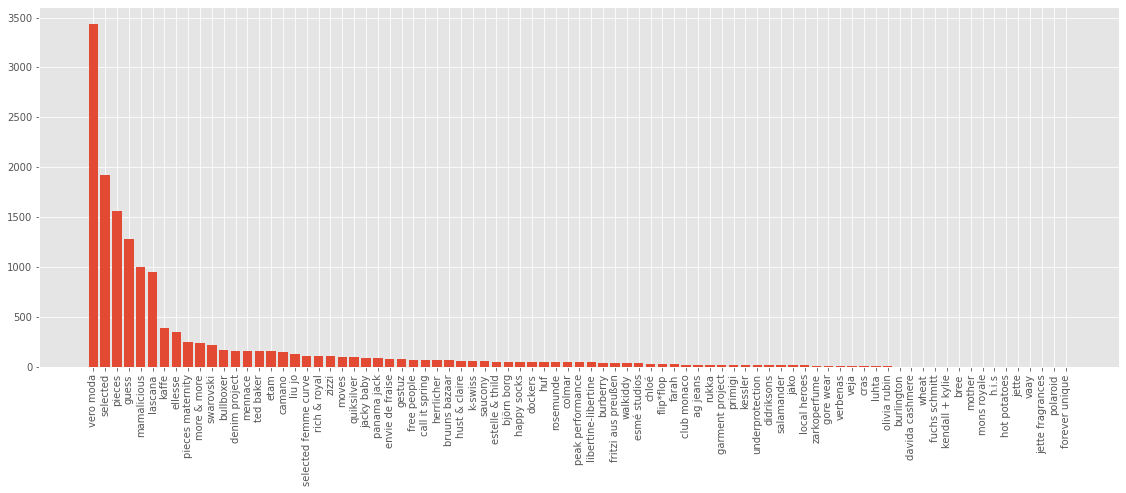

In [175]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(plt_zal_brands,zal_brands_df['frequency'])
plt.xticks(rotation = 90)
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


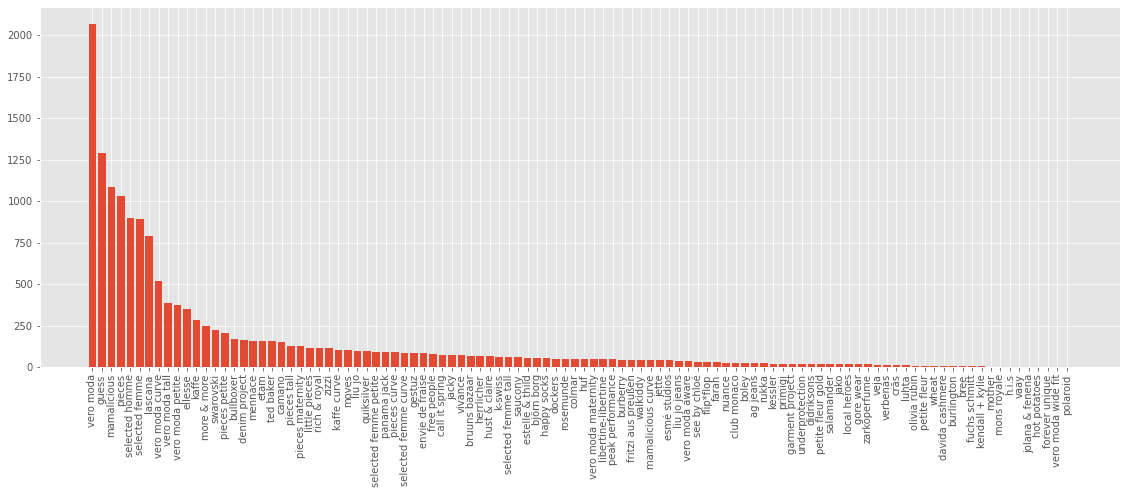

In [174]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(plt_comp_brands,comp_brands_df['frequency'])
plt.xticks(rotation = 90)
plt.show()

In [176]:
df

,offer_id,shop,brand,color_title_desc,offer_id_1,shop_1,brand_1,color_title_desc_1,langestim,langestim_1
0,b33f55d6-0149-4063-8b63-3eeae63562a2,zalando,swarovski,creativity halskette silberfarben k85009 silv...,ad5ceb87-0254-4171-b650-1d4d09f48efc,aboutyou,swarovski,kette silber weiß silber unisex - onesize ...,53.571429,42.857143
1,f04bef4a-f771-4749-914c-1b22718523b8,zalando,swarovski,lifelong bangle armband roségoldfarben k85009...,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,aboutyou,swarovski,armreif rosegold gold unisex - intern. acces...,41.935484,23.076923
2,396c292a-cda8-4477-ac67-86701fc8ab95,zalando,swarovski,eternal flower bangle fly armband silberfarben...,7d19213c-b3ea-406a-ac8e-8299823c7bb4,aboutyou,swarovski,armreif 'eternal flower' rosegold silber s...,34.285714,46.666667
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,zalando,swarovski,angelic bracelet armband silberfarben k85009 c...,22344dcd-2eca-4576-a89d-916cc47f6cb4,aboutyou,swarovski,armband silber silber unisex - onesize (ones...,51.612903,47.887324
4,87b7841b-f44e-4652-ace4-2ac975510226,zalando,swarovski,constella bangle armband weiß k85009 rosegold-...,c2f1a132-c013-4e78-8582-6d3001e05cbf,aboutyou,swarovski,armband weiß rosegold gold modeschmuck gol...,35.483871,14.285714
...,...,...,...,...,...,...,...,...,...,...
15165,29ffe4d1-c298-473c-a6da-b568e2a828c0,zalando,guess,uhr silberfarben k89725 analog edelstahl silve...,c0595145-bf4c-4d86-86e1-dfb4b07da767,aboutyou,guess,guess quarzuhr silber silber female guess mo...,50.000000,14.417178
15166,b5c8c045-0185-4515-95f9-ad10a65026fc,zalando,guess,uhr goldfarben k89725 analog edelstahl gold-co...,d515e41e-f680-45e1-a029-0650ac8cf20e,aboutyou,guess,uhr gold silber gold female guess modeschm...,48.000000,13.173653
15167,cd874fd4-a2d6-4e02-a5b5-514f68148027,zalando,guess,chronograph roségoldfarben k89725 chronograph ...,4ab54165-938d-43df-9f3e-48da066c873d,aboutyou,guess,uhr rosegold gold female guess modeschmuck m...,50.000000,13.569322
15168,92a6d277-d460-42c5-bc12-343dd800f40a,zalando,guess,uhr roségoldfarben k89725 analog edelstahl ros...,8992e0b1-3a27-4e3e-be9a-42c014826a38,aboutyou,guess,uhr gold rosegold gold female mit chronogr...,48.148148,13.167260


In [195]:
df[df['shop_1']=='aboutyou']

,offer_id,shop,brand,color_title_desc,offer_id_1,shop_1,brand_1,color_title_desc_1,langestim,langestim_1
0,b33f55d6-0149-4063-8b63-3eeae63562a2,zalando,swarovski,creativity halskette silberfarben k85009 silv...,ad5ceb87-0254-4171-b650-1d4d09f48efc,aboutyou,swarovski,kette silber weiß silber unisex - onesize ...,53.571429,42.857143
1,f04bef4a-f771-4749-914c-1b22718523b8,zalando,swarovski,lifelong bangle armband roségoldfarben k85009...,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,aboutyou,swarovski,armreif rosegold gold unisex - intern. acces...,41.935484,23.076923
2,396c292a-cda8-4477-ac67-86701fc8ab95,zalando,swarovski,eternal flower bangle fly armband silberfarben...,7d19213c-b3ea-406a-ac8e-8299823c7bb4,aboutyou,swarovski,armreif 'eternal flower' rosegold silber s...,34.285714,46.666667
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,zalando,swarovski,angelic bracelet armband silberfarben k85009 c...,22344dcd-2eca-4576-a89d-916cc47f6cb4,aboutyou,swarovski,armband silber silber unisex - onesize (ones...,51.612903,47.887324
4,87b7841b-f44e-4652-ace4-2ac975510226,zalando,swarovski,constella bangle armband weiß k85009 rosegold-...,c2f1a132-c013-4e78-8582-6d3001e05cbf,aboutyou,swarovski,armband weiß rosegold gold modeschmuck gol...,35.483871,14.285714
...,...,...,...,...,...,...,...,...,...,...
15165,29ffe4d1-c298-473c-a6da-b568e2a828c0,zalando,guess,uhr silberfarben k89725 analog edelstahl silve...,c0595145-bf4c-4d86-86e1-dfb4b07da767,aboutyou,guess,guess quarzuhr silber silber female guess mo...,50.000000,14.417178
15166,b5c8c045-0185-4515-95f9-ad10a65026fc,zalando,guess,uhr goldfarben k89725 analog edelstahl gold-co...,d515e41e-f680-45e1-a029-0650ac8cf20e,aboutyou,guess,uhr gold silber gold female guess modeschm...,48.000000,13.173653
15167,cd874fd4-a2d6-4e02-a5b5-514f68148027,zalando,guess,chronograph roségoldfarben k89725 chronograph ...,4ab54165-938d-43df-9f3e-48da066c873d,aboutyou,guess,uhr rosegold gold female guess modeschmuck m...,50.000000,13.569322
15168,92a6d277-d460-42c5-bc12-343dd800f40a,zalando,guess,uhr roségoldfarben k89725 analog edelstahl ros...,8992e0b1-3a27-4e3e-be9a-42c014826a38,aboutyou,guess,uhr gold rosegold gold female mit chronogr...,48.148148,13.167260


In [183]:
#language % code 
#D:\product_matching\prod_match\lite\langed
zallang = df[df['shop']=='zalando']['langestim'].values.tolist()
complang = df[df['shop_1']=='aboutyou']['langestim_1'].values.tolist()

In [189]:
zalsents = df[df['shop']=='zalando']['color_title_desc'].values.tolist()
compsents = df[df['shop_1']=='aboutyou']['color_title_desc_1'].values.tolist()

In [197]:
zaltoks = [word_tokenize(i) for i in zalsents]
comptoks = [word_tokenize(i) for i in compsents]

In [199]:
len_zaltoks = [len(i) for i in zaltoks]
len_comptoks = [len(i) for i in comptoks]

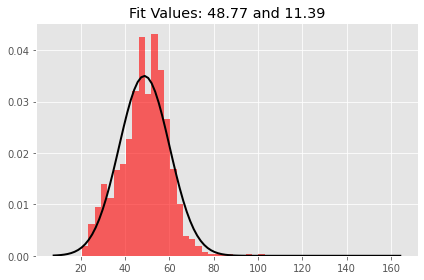

In [202]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
  
# Generate some data for this 
# demonstration.
data = len_zaltoks
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(data) 
  
# Plot the histogram.
plt.hist(data, bins=50, density=True, alpha=0.6, color='red')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

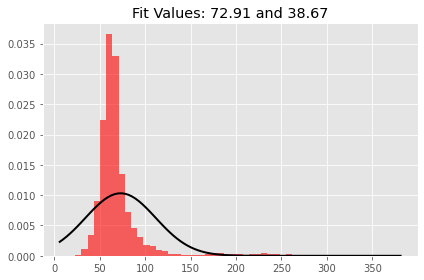

In [203]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
  
# Generate some data for this 
# demonstration.
data = len_comptoks
  
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(data) 
  
# Plot the histogram.
plt.hist(data, bins=50, density=True, alpha=0.6, color='red')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

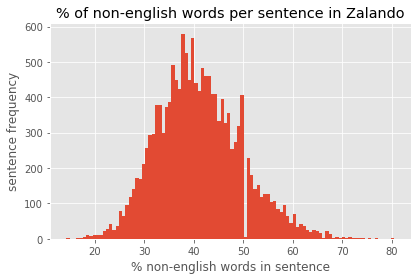

0.4020992819791189


In [204]:
fig, ax = plt.subplots(1,1)

# Set title
ax.set_title("% of non-english words per sentence in Zalando")
  
# adding labels
ax.set_ylabel('sentence frequency')
ax.set_xlabel('% non-english words in sentence')

plt.style.use('ggplot')
plt.hist(zallang,  bins= 100)
plt.show()

print (skew(zallang))

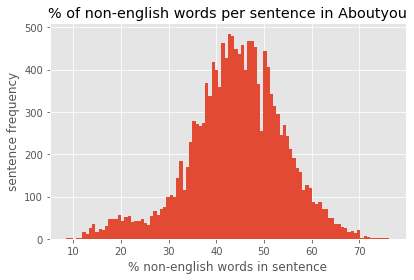

-0.3994032893366944


In [205]:
fig, ax = plt.subplots(1,1)

# Set title
ax.set_title("% of non-english words per sentence in Aboutyou")
  
# adding labels
ax.set_ylabel('sentence frequency')
ax.set_xlabel('% non-english words in sentence')

plt.style.use('ggplot')
plt.hist(complang,  bins= 100)
plt.show()

print (skew(complang))

In [206]:
zaltoks1 = [i for j in zaltoks for i in j]
comptoks1 = [i for j in comptoks for i in j]

In [207]:
zaltoks1 = [i for i in zaltoks1 if i not in list(punctuation)]
comptoks1 = [i for i in comptoks1 if i not in list(punctuation)]

In [208]:
def word_frequency(words, ngram):
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

In [209]:
zal_unigram_freq = Counter(word_frequency(zaltoks1, 1))
comp_unigram_freq = Counter(word_frequency(comptoks1, 1))

zal_bigram_freq = Counter(word_frequency(zaltoks1, 2))
comp_bigram_freq = Counter(word_frequency(comptoks1, 2))

zal_trigram_freq = Counter(word_frequency(zaltoks1, 3))
comp_trigram_freq = Counter(word_frequency(comptoks1, 3))

zal_fourgram_freq = Counter(word_frequency(zaltoks1, 4))
comp_fourgram_freq = Counter(word_frequency(comptoks1, 4))

In [210]:
zal_unigram_df = pd.DataFrame(zal_unigram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
comp_unigram_df = pd.DataFrame(comp_unigram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

In [211]:
zal_bigram_df = pd.DataFrame(zal_bigram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
comp_bigram_df = pd.DataFrame(comp_bigram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

In [212]:
zal_trigram_df = pd.DataFrame(zal_trigram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
comp_trigram_df = pd.DataFrame(comp_trigram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

In [213]:
zal_fourgram_df = pd.DataFrame(zal_fourgram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
comp_fourgram_df = pd.DataFrame(comp_fourgram_freq.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

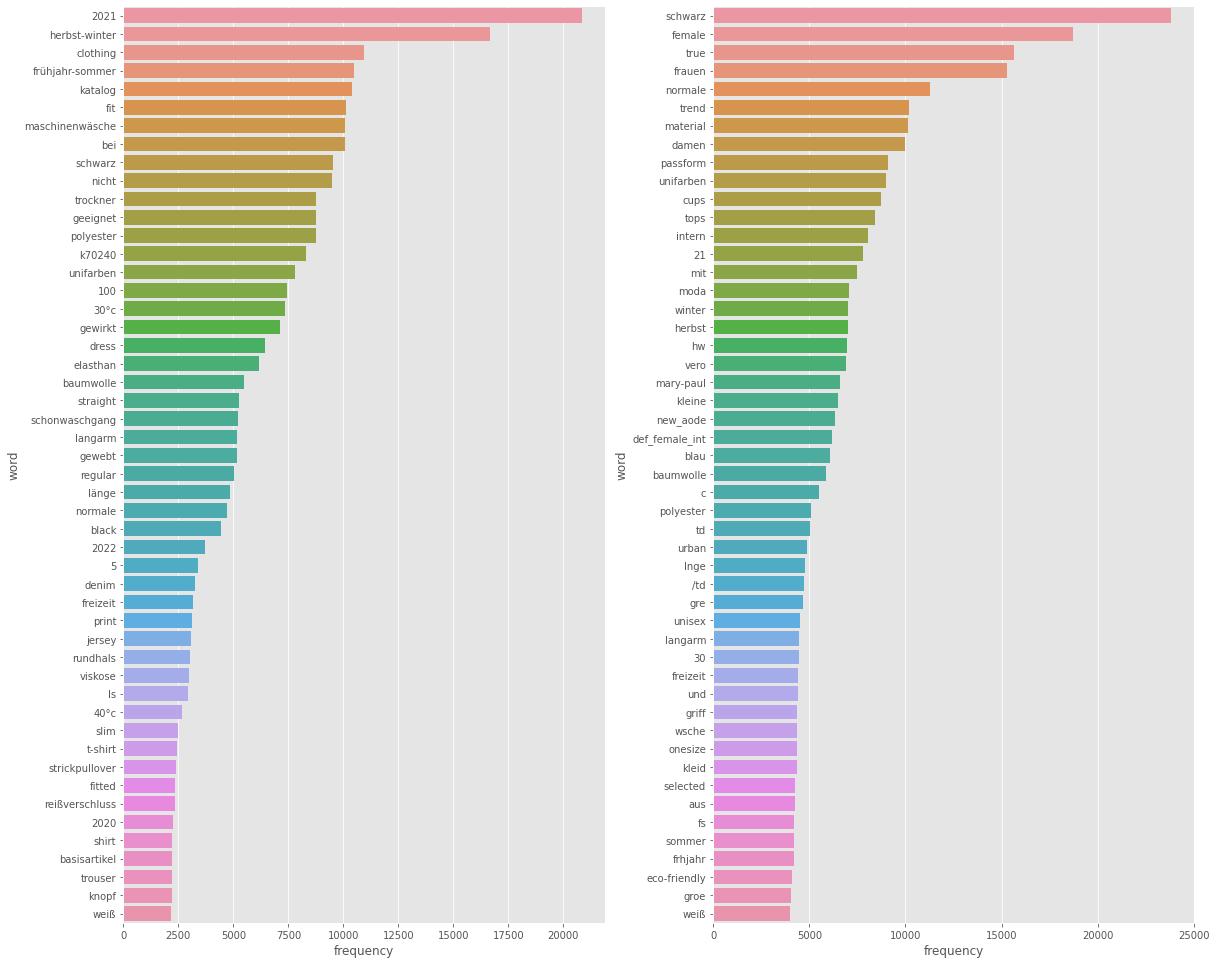

In [214]:
plt.rcParams["figure.figsize"] = [17.00, 13.50]
plt.rcParams["figure.autolayout"] = True

fig, ax =plt.subplots(1,2)
sns.barplot(ax=ax[0], x='frequency',y='word',data=zal_unigram_df.head(50))
sns.barplot(ax=ax[1], x='frequency',y='word',data=comp_unigram_df.head(50))
fig.show()

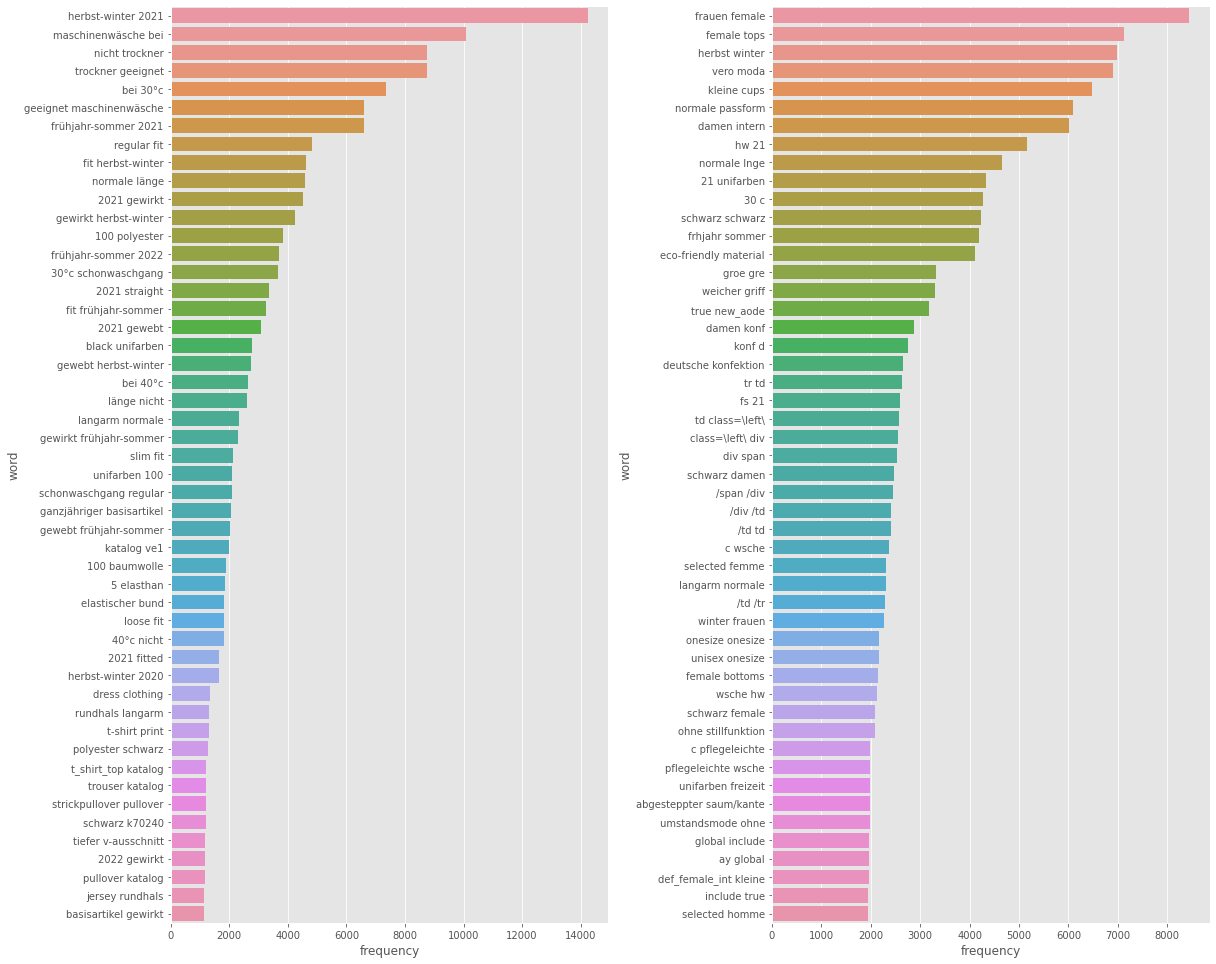

In [215]:
plt.rcParams["figure.figsize"] = [17.00, 13.50]
plt.rcParams["figure.autolayout"] = True

fig, ax =plt.subplots(1,2)
sns.barplot(ax=ax[0], x='frequency',y='word',data=zal_bigram_df.head(50))
sns.barplot(ax=ax[1], x='frequency',y='word',data=comp_bigram_df.head(50))
fig.show()

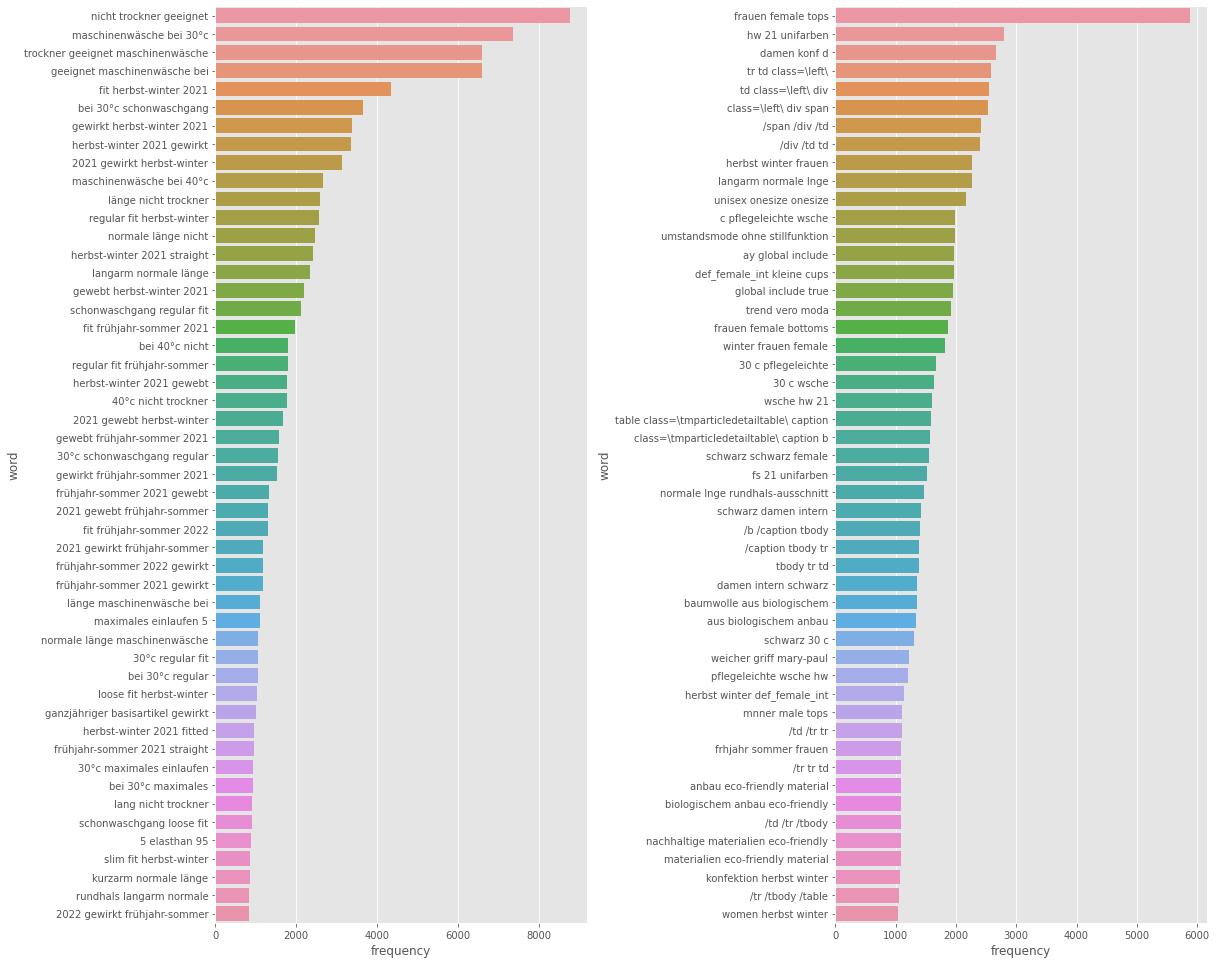

In [216]:
plt.rcParams["figure.figsize"] = [17.00, 13.50]
plt.rcParams["figure.autolayout"] = True

fig, ax =plt.subplots(1,2)
sns.barplot(ax=ax[0], x='frequency',y='word',data=zal_trigram_df.head(50))
sns.barplot(ax=ax[1], x='frequency',y='word',data=comp_trigram_df.head(50))
fig.show()

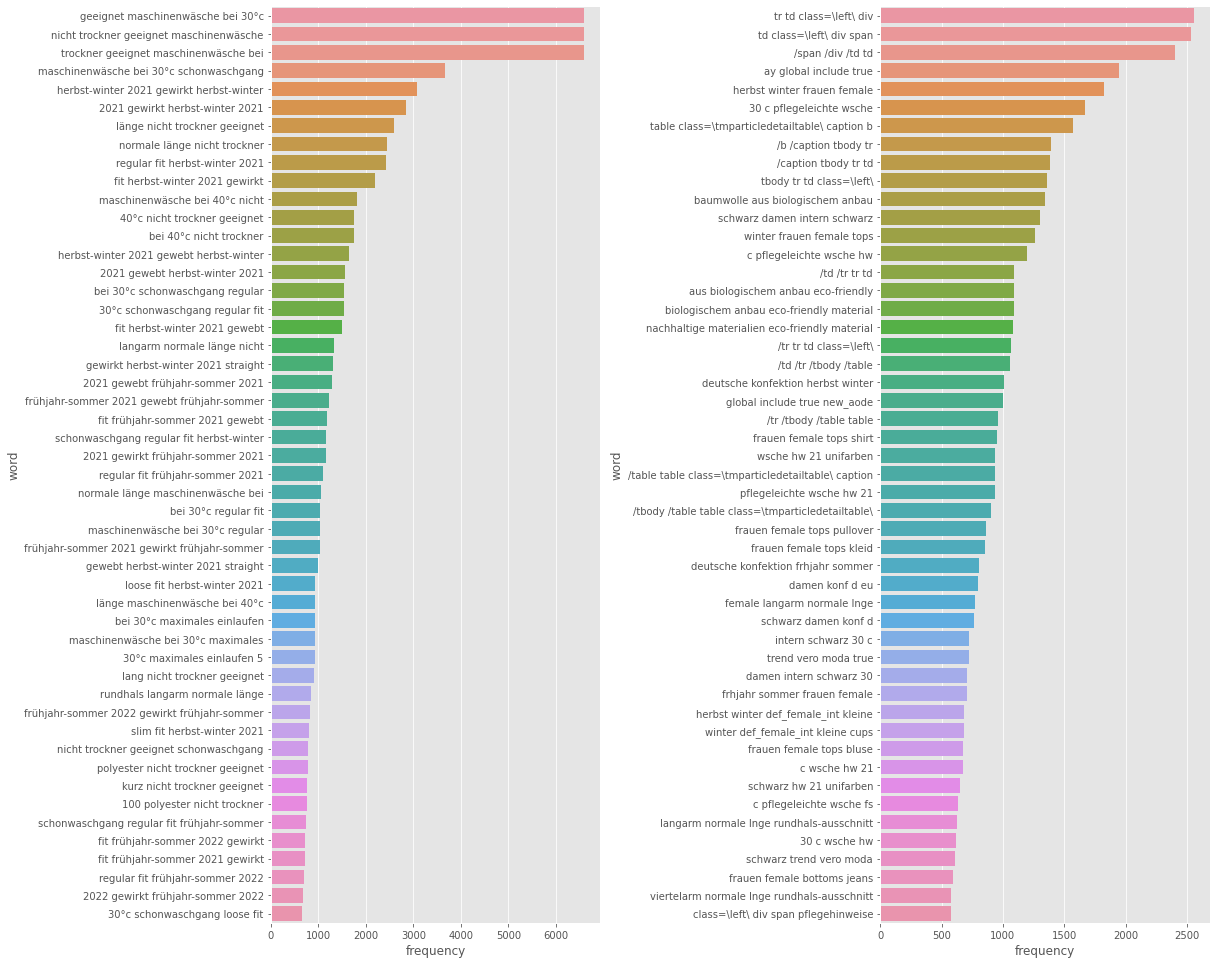

In [217]:
plt.rcParams["figure.figsize"] = [17.00, 13.50]
plt.rcParams["figure.autolayout"] = True

fig, ax =plt.subplots(1,2)
sns.barplot(ax=ax[0], x='frequency',y='word',data=zal_fourgram_df.head(50))
sns.barplot(ax=ax[1], x='frequency',y='word',data=comp_fourgram_df.head(50))
fig.show()

In [218]:
# Model building using Training Data

In [219]:
import datetime
# ct stores current time
ct = datetime.datetime.now()

In [221]:
# Prepare Synthetic data of no matches between shop offers.

In [220]:
def create_synthetic_data(df, iterations):
    """Creates synthetic training data from the correctly matched
    data by grouping on the cluster_label column and reshuffling
    the internal_name to create data that contain incorrect matches.
    """

    df_output = df

    i = 1
    while i <= iterations:

        # Create synthetic data by shuffling the column using a groupby
        df_s = df[['external_name','internal_name','category_label']].copy()
        df_s['shuffled_internal_name'] = df_s['internal_name']
        df_s['shuffled_internal_name'] = df_s.groupby('category_label')['internal_name'].transform(np.random.permutation)

        # Add the correct value to the match column
        df_s['match'] = np.where(df_s['internal_name'] == df_s['shuffled_internal_name'], 1, 0)
        
        # Create internal name column
        df_s['internal_name'] = np.where(df_s['shuffled_internal_name']!='', 
                                        df_s['shuffled_internal_name'],
                                        df_s['internal_name'])

        df_output = df_output.append(df_s)
        df_output = df_output.drop(columns=['shuffled_internal_name'])

        i += 1

    return df_output

In [222]:
df

,offer_id,shop,brand,color_title_desc,offer_id_1,shop_1,brand_1,color_title_desc_1,langestim,langestim_1
0,b33f55d6-0149-4063-8b63-3eeae63562a2,zalando,swarovski,creativity halskette silberfarben k85009 silv...,ad5ceb87-0254-4171-b650-1d4d09f48efc,aboutyou,swarovski,kette silber weiß silber unisex - onesize ...,53.571429,42.857143
1,f04bef4a-f771-4749-914c-1b22718523b8,zalando,swarovski,lifelong bangle armband roségoldfarben k85009...,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,aboutyou,swarovski,armreif rosegold gold unisex - intern. acces...,41.935484,23.076923
2,396c292a-cda8-4477-ac67-86701fc8ab95,zalando,swarovski,eternal flower bangle fly armband silberfarben...,7d19213c-b3ea-406a-ac8e-8299823c7bb4,aboutyou,swarovski,armreif 'eternal flower' rosegold silber s...,34.285714,46.666667
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,zalando,swarovski,angelic bracelet armband silberfarben k85009 c...,22344dcd-2eca-4576-a89d-916cc47f6cb4,aboutyou,swarovski,armband silber silber unisex - onesize (ones...,51.612903,47.887324
4,87b7841b-f44e-4652-ace4-2ac975510226,zalando,swarovski,constella bangle armband weiß k85009 rosegold-...,c2f1a132-c013-4e78-8582-6d3001e05cbf,aboutyou,swarovski,armband weiß rosegold gold modeschmuck gol...,35.483871,14.285714
...,...,...,...,...,...,...,...,...,...,...
15165,29ffe4d1-c298-473c-a6da-b568e2a828c0,zalando,guess,uhr silberfarben k89725 analog edelstahl silve...,c0595145-bf4c-4d86-86e1-dfb4b07da767,aboutyou,guess,guess quarzuhr silber silber female guess mo...,50.000000,14.417178
15166,b5c8c045-0185-4515-95f9-ad10a65026fc,zalando,guess,uhr goldfarben k89725 analog edelstahl gold-co...,d515e41e-f680-45e1-a029-0650ac8cf20e,aboutyou,guess,uhr gold silber gold female guess modeschm...,48.000000,13.173653
15167,cd874fd4-a2d6-4e02-a5b5-514f68148027,zalando,guess,chronograph roségoldfarben k89725 chronograph ...,4ab54165-938d-43df-9f3e-48da066c873d,aboutyou,guess,uhr rosegold gold female guess modeschmuck m...,50.000000,13.569322
15168,92a6d277-d460-42c5-bc12-343dd800f40a,zalando,guess,uhr roségoldfarben k89725 analog edelstahl ros...,8992e0b1-3a27-4e3e-be9a-42c014826a38,aboutyou,guess,uhr gold rosegold gold female mit chronogr...,48.148148,13.167260


In [246]:
exdf = df[["offer_id_1", "color_title_desc_1", "offer_id", "color_title_desc", "brand"]]
exdf.columns = ["offer_id_1", "external", "offer_id", "internal", "category_label"]

In [225]:
def concatcols(x,y):
    return x+"^"+y

In [247]:
exdf['external_name'] = exdf.apply(lambda x : concatcols(x['offer_id_1'], x['external']), axis=1)
exdf['internal_name'] = exdf.apply(lambda x : concatcols(x['offer_id'], x['internal']), axis=1)
exdf = exdf[['external_name', "internal_name", 'category_label']]
exdf['match'] = 1
exdf.head()

,external_name,internal_name,category_label,match
0,ad5ceb87-0254-4171-b650-1d4d09f48efc^kette sil...,b33f55d6-0149-4063-8b63-3eeae63562a2^creativit...,swarovski,1
1,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2^armreif r...,f04bef4a-f771-4749-914c-1b22718523b8^lifelong ...,swarovski,1
2,7d19213c-b3ea-406a-ac8e-8299823c7bb4^armreif '...,396c292a-cda8-4477-ac67-86701fc8ab95^eternal f...,swarovski,1
3,22344dcd-2eca-4576-a89d-916cc47f6cb4^armband s...,e72b5d05-fd06-46e9-a183-5e2e26ed18bb^angelic b...,swarovski,1
4,c2f1a132-c013-4e78-8582-6d3001e05cbf^armband w...,87b7841b-f44e-4652-ace4-2ac975510226^constella...,swarovski,1


In [248]:
exdf_output = create_synthetic_data(exdf, 10)
exdf_output.tail()

,external_name,internal_name,category_label,match
15165,c0595145-bf4c-4d86-86e1-dfb4b07da767^guess qua...,827ec5da-09f6-4ae3-9384-070eb0fbbbb4^carrie s...,guess,0
15166,d515e41e-f680-45e1-a029-0650ac8cf20e^uhr gold ...,77fb5625-9b3f-4a1d-9392-68839858f259^anna uhr ...,guess,0
15167,4ab54165-938d-43df-9f3e-48da066c873d^uhr roseg...,e981fea5-a8ad-4d39-9b14-3658ffe9fd92^noelle mi...,guess,0
15168,8992e0b1-3a27-4e3e-be9a-42c014826a38^uhr gold ...,3fe1192a-0219-4c65-95a6-101490607deb^rasida sc...,guess,0
15169,e97d7382-a7bb-45e2-a401-4d9eb9b2bbde^uhr weiß ...,d41f2c4a-776f-4a89-8d22-0029f3ea383f^ladies sp...,guess,0


In [229]:
exdf_output.shape

(166870, 4)

In [249]:
exdf_output[['offer_id_1', "external_name2"]] = exdf_output['external_name'].str.split("^", expand=True)
exdf_output[['offer_id', "internal_name2"]] = exdf_output['internal_name'].str.split("^", expand=True)

In [250]:
exdf_output

,external_name,internal_name,category_label,match,offer_id_1,external_name2,offer_id,internal_name2
0,ad5ceb87-0254-4171-b650-1d4d09f48efc^kette sil...,b33f55d6-0149-4063-8b63-3eeae63562a2^creativit...,swarovski,1,ad5ceb87-0254-4171-b650-1d4d09f48efc,kette silber weiß silber unisex - onesize ...,b33f55d6-0149-4063-8b63-3eeae63562a2,creativity halskette silberfarben k85009 silv...
1,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2^armreif r...,f04bef4a-f771-4749-914c-1b22718523b8^lifelong ...,swarovski,1,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,armreif rosegold gold unisex - intern. acces...,f04bef4a-f771-4749-914c-1b22718523b8,lifelong bangle armband roségoldfarben k85009...
2,7d19213c-b3ea-406a-ac8e-8299823c7bb4^armreif '...,396c292a-cda8-4477-ac67-86701fc8ab95^eternal f...,swarovski,1,7d19213c-b3ea-406a-ac8e-8299823c7bb4,armreif 'eternal flower' rosegold silber s...,396c292a-cda8-4477-ac67-86701fc8ab95,eternal flower bangle fly armband silberfarben...
3,22344dcd-2eca-4576-a89d-916cc47f6cb4^armband s...,e72b5d05-fd06-46e9-a183-5e2e26ed18bb^angelic b...,swarovski,1,22344dcd-2eca-4576-a89d-916cc47f6cb4,armband silber silber unisex - onesize (ones...,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,angelic bracelet armband silberfarben k85009 c...
4,c2f1a132-c013-4e78-8582-6d3001e05cbf^armband w...,87b7841b-f44e-4652-ace4-2ac975510226^constella...,swarovski,1,c2f1a132-c013-4e78-8582-6d3001e05cbf,armband weiß rosegold gold modeschmuck gol...,87b7841b-f44e-4652-ace4-2ac975510226,constella bangle armband weiß k85009 rosegold-...
...,...,...,...,...,...,...,...,...
15165,c0595145-bf4c-4d86-86e1-dfb4b07da767^guess qua...,827ec5da-09f6-4ae3-9384-070eb0fbbbb4^carrie s...,guess,0,c0595145-bf4c-4d86-86e1-dfb4b07da767,guess quarzuhr silber silber female guess mo...,827ec5da-09f6-4ae3-9384-070eb0fbbbb4,carrie slip grau k70603 grey meliert 95% baum...
15166,d515e41e-f680-45e1-a029-0650ac8cf20e^uhr gold ...,77fb5625-9b3f-4a1d-9392-68839858f259^anna uhr ...,guess,0,d515e41e-f680-45e1-a029-0650ac8cf20e,uhr gold silber gold female guess modeschm...,77fb5625-9b3f-4a1d-9392-68839858f259,anna uhr weiß analog silikon white schmuckkris...
15167,4ab54165-938d-43df-9f3e-48da066c873d^uhr roseg...,e981fea5-a8ad-4d39-9b14-3658ffe9fd92^noelle mi...,guess,0,4ab54165-938d-43df-9f3e-48da066c873d,uhr rosegold gold female guess modeschmuck m...,e981fea5-a8ad-4d39-9b14-3658ffe9fd92,noelle mini crossbody flap umhängetasche schwa...
15168,8992e0b1-3a27-4e3e-be9a-42c014826a38^uhr gold ...,3fe1192a-0219-4c65-95a6-101490607deb^rasida sc...,guess,0,8992e0b1-3a27-4e3e-be9a-42c014826a38,uhr gold rosegold gold female mit chronogr...,3fe1192a-0219-4c65-95a6-101490607deb,rasida schnürstiefelette schwarz leder zierste...


In [251]:
exdf_output = exdf_output[["offer_id", "internal_name2", 'offer_id_1', "external_name2", "category_label", "match"]]
exdf_output.columns = ["offer_id", "internal_name", 'offer_id_1', "external_name", "category_label", "match"]

In [252]:
exdf_output.head()

,offer_id,internal_name,offer_id_1,external_name,category_label,match
0,b33f55d6-0149-4063-8b63-3eeae63562a2,creativity halskette silberfarben k85009 silv...,ad5ceb87-0254-4171-b650-1d4d09f48efc,kette silber weiß silber unisex - onesize ...,swarovski,1
1,f04bef4a-f771-4749-914c-1b22718523b8,lifelong bangle armband roségoldfarben k85009...,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,armreif rosegold gold unisex - intern. acces...,swarovski,1
2,396c292a-cda8-4477-ac67-86701fc8ab95,eternal flower bangle fly armband silberfarben...,7d19213c-b3ea-406a-ac8e-8299823c7bb4,armreif 'eternal flower' rosegold silber s...,swarovski,1
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,angelic bracelet armband silberfarben k85009 c...,22344dcd-2eca-4576-a89d-916cc47f6cb4,armband silber silber unisex - onesize (ones...,swarovski,1
4,87b7841b-f44e-4652-ace4-2ac975510226,constella bangle armband weiß k85009 rosegold-...,c2f1a132-c013-4e78-8582-6d3001e05cbf,armband weiß rosegold gold modeschmuck gol...,swarovski,1


In [253]:
def concati(x,y):
    return x+" "+y

In [254]:
exdf_output['brandfused_internal_name'] = exdf_output.apply(lambda x : concati(x['category_label'], x['internal_name']), axis=1)
exdf_output['brandfused_external_name'] = exdf_output.apply(lambda x : concati(x['category_label'], x['external_name']), axis=1)

In [255]:
exdf_output['matched'] = exdf_output['match'].apply(lambda x: 'entailment' if x==1 else "contradiction")

In [256]:
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split

In [257]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(exdf_output, target = 'match', train_size=0.8, valid_size=0.1, test_size=0.1)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(133496, 8)
(133496,)
(16687, 8)
(16687,)
(16687, 8)
(16687,)


(None, None)

In [258]:
X_train

,offer_id,internal_name,offer_id_1,external_name,category_label,brandfused_internal_name,brandfused_external_name,matched
880,e5d9ba55-e8b7-4eb8-937c-2ae21d112edb,bella ohrringe roségoldfarben k85009 rose gold...,58b8a09f-ba49-4679-8d61-047eb77188a6,kette rosegold weiß gold collier swarovski...,swarovski,swarovski bella ohrringe roségoldfarben k85009...,swarovski kette rosegold weiß gold collier...,contradiction
4532,718e09b5-d7cd-43e7-8229-837e0466836d,t-shirt print schwarz k73264 black deep unifar...,25b28af8-e9bd-4663-a152-415b1a7f36db,t-shirt 'clast' schwarz beige schwarz fema...,kaffe,kaffe t-shirt print schwarz k73264 black deep ...,kaffe t-shirt 'clast' schwarz beige schwar...,entailment
14048,2f5439f6-9675-428f-8e8e-21056678d0b9,vmhot seven mr push pant jeans skinny fit khak...,3025e520-038e-430e-a8d4-60e6b196ab5f,jeans 'ellie' black denim schwarz female jea...,vero moda,vero moda vmhot seven mr push pant jeans skinn...,vero moda jeans 'ellie' black denim schwarz ...,contradiction
12909,fd9b4ae7-e50c-43bd-b4dd-666e1b6a689a,strickjacke schwarz k70240 eingrifftaschen bla...,eede2cbb-2b52-4afc-83f1-2dba6cebaff8,strickjacke schwarz schwarz vero moda frauen...,vero moda,vero moda strickjacke schwarz k70240 eingrifft...,vero moda strickjacke schwarz schwarz vero m...,entailment
2897,42ea764d-dad1-43e5-a5c0-4bff241f4d39,uhr goldfarben k89725 analog edelstahl gold-co...,3061e3c8-7c31-4f90-8038-ee1fdc036b51,schnürboots 'vigo' schwarz schwarz male glat...,guess,guess uhr goldfarben k89725 analog edelstahl g...,guess schnürboots 'vigo' schwarz schwarz mal...,contradiction
...,...,...,...,...,...,...,...,...
6751,15fe6cc7-818a-415c-a3da-0018ba184807,mlmandy midi skirt maxirock silberfarben k7024...,31f37554-6493-4b7e-a24e-b805cc612d59,shirt 'hazel' blau blau female jersey vierte...,mamalicious,mamalicious mlmandy midi skirt maxirock silber...,mamalicious shirt 'hazel' blau blau female j...,contradiction
180,abf1b85b-914a-45a0-aa42-1752bcf3fbec,bea convertible umhängetasche beige handyfach...,8ef526c5-29c1-41a8-8907-631c851d3fc8,umhängetasche 'bea' offwhite gold weiß gue...,guess,guess bea convertible umhängetasche beige han...,guess umhängetasche 'bea' offwhite gold we...,entailment
6442,c87d31a4-bd3b-47f7-8b61-41cb5f77d553,mlstarla t-shirt basic schwarz black unifarben...,5aa5780a-3090-42ec-8858-fae5aeebfc8d,umstandskleid 'birke' schwarz mischfarben ...,mamalicious,mamalicious mlstarla t-shirt basic schwarz bla...,mamalicious umstandskleid 'birke' schwarz mi...,contradiction
8964,11d2a566-c598-4a65-986d-b78d46a53e2c,pcmcindy bluse blau brustabnäher blue geblümt ...,c43aa245-483d-4e61-95a7-d0bc391f08f9,kleid 'tyla' weiß rauchblau weiß female ba...,pieces maternity,pieces maternity pcmcindy bluse blau brustabnä...,pieces maternity kleid 'tyla' weiß rauchblau...,contradiction


In [259]:
y_train

880      0
4532     1
14048    0
12909    1
2897     0
        ..
6751     0
180      1
6442     0
8964     0
13599    0
Name: match, Length: 133496, dtype: int64

In [260]:
zalab_train = pd.concat([X_train, y_train], axis=1)
zalab_valid = pd.concat([X_valid, y_valid], axis=1)
zalab_test = pd.concat([X_test, y_test], axis=1)

In [263]:
# New Master data
exdf_output.head(3)

,offer_id,internal_name,offer_id_1,external_name,category_label,match,brandfused_internal_name,brandfused_external_name,matched
0,b33f55d6-0149-4063-8b63-3eeae63562a2,creativity halskette silberfarben k85009 silv...,ad5ceb87-0254-4171-b650-1d4d09f48efc,kette silber weiß silber unisex - onesize ...,swarovski,1,swarovski creativity halskette silberfarben k...,swarovski kette silber weiß silber unisex ...,entailment
1,f04bef4a-f771-4749-914c-1b22718523b8,lifelong bangle armband roségoldfarben k85009...,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,armreif rosegold gold unisex - intern. acces...,swarovski,1,swarovski lifelong bangle armband roségoldfar...,swarovski armreif rosegold gold unisex - int...,entailment
2,396c292a-cda8-4477-ac67-86701fc8ab95,eternal flower bangle fly armband silberfarben...,7d19213c-b3ea-406a-ac8e-8299823c7bb4,armreif 'eternal flower' rosegold silber s...,swarovski,1,swarovski eternal flower bangle fly armband si...,swarovski armreif 'eternal flower' rosegold ...,entailment


In [264]:
def matching_numbers(external_name, internal_name):

    external_numbers = set(re.findall(r'[0-9]+', external_name))
    internal_numbers = set(re.findall(r'[0-9]+', internal_name))    
    union = external_numbers.union(internal_numbers)
    intersection = external_numbers.intersection(internal_numbers)

    if len(external_numbers)==0 and len(internal_numbers) == 0:
        return 1
    else:
        return (len(intersection)/ len(union))

In [265]:
def engineer_features(df):
    
    print("started at time:- " + str(datetime.datetime.now()))

    df['internal_name'] = df['internal_name'].str.lower()
    df['external_name'] = df['external_name'].str.lower()

    df['levenshtein_distance'] = df.apply(
    lambda x: jf.levenshtein_distance(x['external_name'], 
                                      x['internal_name']), axis=1)
    
    print("levenshtein_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['damerau_levenshtein_distance'] = df.apply(
    lambda x: jf.damerau_levenshtein_distance(x['external_name'], 
                                              x['internal_name']), axis=1)
    
    print("damerau_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['hamming_distance'] = df.apply(
    lambda x: jf.hamming_distance(x['external_name'], 
                                  x['internal_name']), axis=1)
    
    print("hamming_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['jaro_similarity'] = df.apply(
    lambda x: jf.jaro_similarity(x['external_name'], 
                                  x['internal_name']), axis=1)
    
    print("jaro_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['jaro_winkler_similarity'] = df.apply(
    lambda x: jf.jaro_winkler_similarity(x['external_name'], 
                                         x['internal_name']), axis=1)
    
    print("jaro_winkler_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['match_rating_comparison'] = df.apply(
    lambda x: jf.match_rating_comparison(x['external_name'], 
                                         x['internal_name']), axis=1).fillna(0).astype(int)
    
    print("match_rating_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['ratio'] = df.apply(
    lambda x: fuzz.ratio(x['external_name'], 
                         x['internal_name']), axis=1)
    
    print("ratio_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['partial_ratio'] = df.apply(
    lambda x: fuzz.partial_ratio(x['external_name'], 
                                 x['internal_name']), axis=1)
    
    print("partial_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['token_sort_ratio'] = df.apply(
    lambda x: fuzz.token_sort_ratio(x['external_name'], 
                                    x['internal_name']), axis=1)
    
    print("token_sort_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['token_set_ratio'] = df.apply(
    lambda x: fuzz.token_set_ratio(x['external_name'], 
                                   x['internal_name']), axis=1)
    
    print("token_set_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['w_ratio'] = df.apply(
    lambda x: fuzz.WRatio(x['external_name'], 
                          x['internal_name']), axis=1)
    
    print("w_ratio_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['uq_ratio'] = df.apply(
    lambda x: fuzz.UQRatio(x['external_name'], 
                          x['internal_name']), axis=1)
    
    print("uq_ratio_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['q_ratio'] = df.apply(
    lambda x: fuzz.QRatio(x['external_name'], 
                          x['internal_name']), axis=1)
    
    print("q_ratio_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['matching_numbers'] = df.apply(
    lambda x: matching_numbers(x['external_name'], 
                               x['internal_name']), axis=1)
    
    print("matching_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['matching_numbers_log'] = (df['matching_numbers']+1).apply(np.log)
    
    print("matching_numbers_log_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['log_fuzz_score'] = (df['ratio'] + df['partial_ratio'] + 
                            df['token_sort_ratio'] + df['token_set_ratio']).apply(np.log)
    
    print("log_fuzz_completed", "completed at time:- " + str(datetime.datetime.now()))

    df['log_fuzz_score_numbers'] = df['log_fuzz_score'] + (df['matching_numbers']).apply(np.log)
    
    print("log_fuzz_score_numbers_completed", "completed at time:- " + str(datetime.datetime.now()))

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(value=0, inplace=True)

    return df

In [268]:
df = exdf_output[['brandfused_internal_name', "brandfused_external_name", 'match']]
df.columns = ['internal_name', 'external_name', 'match']

In [269]:
df.head()

,internal_name,external_name,match
0,swarovski creativity halskette silberfarben k...,swarovski kette silber weiß silber unisex ...,1
1,swarovski lifelong bangle armband roségoldfar...,swarovski armreif rosegold gold unisex - int...,1
2,swarovski eternal flower bangle fly armband si...,swarovski armreif 'eternal flower' rosegold ...,1
3,swarovski angelic bracelet armband silberfarbe...,swarovski armband silber silber unisex - one...,1
4,swarovski constella bangle armband weiß k85009...,swarovski armband weiß rosegold gold modes...,1


In [270]:
df = engineer_features(df)

started at time:- 2022-03-29 06:00:57.608778
levenshtein_completed completed at time:- 2022-03-29 06:02:46.210685
damerau_completed completed at time:- 2022-03-29 06:05:54.689565
hamming_completed completed at time:- 2022-03-29 06:05:56.770116
jaro_completed completed at time:- 2022-03-29 06:06:20.651330
jaro_winkler_completed completed at time:- 2022-03-29 06:06:44.607919
match_rating_completed completed at time:- 2022-03-29 06:06:48.249264
ratio_completed completed at time:- 2022-03-29 06:09:15.678930
partial_completed completed at time:- 2022-03-29 06:28:35.882429
token_sort_completed completed at time:- 2022-03-29 06:31:18.543842
token_set_completed completed at time:- 2022-03-29 06:34:32.446731
w_ratio_completed completed at time:- 2022-03-29 06:55:19.615868
uq_ratio_completed completed at time:- 2022-03-29 06:57:50.613616
q_ratio_completed completed at time:- 2022-03-29 07:00:23.830729
matching_completed completed at time:- 2022-03-29 07:00:29.393400
matching_numbers_log_complete

In [271]:
# df.to_csv(r"D:\product_matching\final_model\ML_model\text2distancemetric_features.csv")

In [272]:
df[df.columns[1:]].corr()['match'][:].sort_values(ascending=False)

match                           1.000000
token_set_ratio                 0.472683
log_fuzz_score                  0.382976
ratio                           0.291000
uq_ratio                        0.287031
log_fuzz_score_numbers          0.271254
q_ratio                         0.266254
matching_numbers                0.239642
matching_numbers_log            0.231909
token_sort_ratio                0.149326
partial_ratio                   0.138967
w_ratio                         0.117147
jaro_winkler_similarity         0.104172
jaro_similarity                 0.080616
hamming_distance               -0.004536
damerau_levenshtein_distance   -0.023765
levenshtein_distance           -0.023853
match_rating_comparison              NaN
Name: match, dtype: float64

In [273]:
X = df[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
       'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
       'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
       'ratio','log_fuzz_score','log_fuzz_score_numbers','match_rating_comparison',
       'q_ratio','uq_ratio','w_ratio']].values
y = df['match'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [275]:
def get_confusion_matrix_values(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

classifiers = {
    "DummyClassifier_stratified":DummyClassifier(strategy='stratified', random_state=0),    
    "KNeighborsClassifier":KNeighborsClassifier(3),
    "XGBClassifier":XGBClassifier(n_estimators=1000, learning_rate=0.1),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "AdaBoostClassifier":AdaBoostClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "Perceptron": Perceptron(max_iter=40, eta0=0.1, random_state=1),
    "MLP": MLPClassifier(),
    "XGBClassifer tuned": XGBClassifier(colsample_bytree=0.8,
                      gamma=0.9,
                      max_depth=20,
                      min_child_weight=1,
                      scale_pos_weight=12,
                      subsample=0.9,
                      n_estimators=50, 
                      learning_rate=0.1)
}

df_results = pd.DataFrame(columns=['model', 'accuracy', 'mae', 'precision',
                                   'recall','f1','roc','run_time','tp','fp',
                                   'tn','fn'])

for key in classifiers:

    start_time = time.time()
    classifier = classifiers[key]
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_pred)
    classification = classification_report(y_test, y_pred, zero_division=0)
    run_time = format(round((time.time() - start_time)/60,2))
    tp, fp, fn, tn = get_confusion_matrix_values(y_test, y_pred)

    row = {'model': key,
           'accuracy': accuracy,
           'mae': mae,
           'precision': precision,
           'recall': recall,
           'f1': f1,
           'roc': roc,
           'run_time': run_time,
           'tp': tp,
           'fp': fp,
           'tn': tn,
           'fn': fn,
          }
    df_results = df_results.append(row, ignore_index=True)

df_results.head(10)

,model,accuracy,mae,precision,recall,f1,roc,run_time,tp,fp,tn,fn
0,DummyClassifier_stratified,0.826771,0.173229,0.096982,0.097104,0.097043,0.500620,0.0,40923,4339,466,4333
1,KNeighborsClassifier,0.916802,0.083198,0.591460,0.427172,0.496068,0.697944,1.01,43846,1416,2050,2749
2,XGBClassifier,0.932462,0.067538,0.717085,0.488018,0.580781,0.733802,1.17,44338,924,2342,2457
3,DecisionTreeClassifier,0.902579,0.097421,0.492289,0.518858,0.505225,0.731061,0.03,42694,2568,2490,2309
4,RandomForestClassifier,0.936278,0.063722,0.742685,0.513024,0.606852,0.747089,0.41,44409,853,2462,2337
5,AdaBoostClassifier,0.925950,0.074050,0.678665,0.432173,0.528071,0.705239,0.12,44280,982,2074,2725
6,GradientBoostingClassifier,0.928647,0.071353,0.696194,0.453636,0.549331,0.716324,0.49,44312,950,2177,2622
7,Perceptron,0.915763,0.084237,0.696622,0.214836,0.328396,0.602458,0.01,44813,449,1031,3768
8,MLP,0.925591,0.074409,0.646322,0.494270,0.560161,0.732796,0.66,43964,1298,2372,2427
9,XGBClassifer tuned,0.922215,0.077785,0.581960,0.669514,0.622674,0.809261,0.48,42954,2308,3213,1586


In [276]:
def get_scale_pos_weight(target, square_root=False, gridsearch=False):
    """Return the scale_pos_weight parameter for the XGBoost model when data are imbalanced.
    The scale_pos_weight parameter is calculated from the ratio of the negative class over
    the positive class. The exact scale_pos_weight sometimes does not give the best result,
    so by passing the gridsearch=True parameter you can return a list of values to test with
    GridSearchCV. In addition, passing square_root=True changes the scale_pos_weight to the
    square root value, which can sometimes be beneficial on extremely imbalanced data.

    :param target: Pandas dataframe column containing the binary target
    :param square_root: Optional boolean parameter to convert to square root on extremely unbalanced data
    :param gridsearch: Optional boolean parameter to return a bracketed list for use in GridSearchCV

    Usage:
        scale_pos_weight = get_scale_pos_weight(df['target'], square_root=False, gridsearch=True)

    """

    import math

    scale_pos_weight = round((len(target) - sum(target)) / sum(target))

    if square_root:
        scale_pos_weight = round(math.sqrt(scale_pos_weight))

    if gridsearch:
        scale_pos_weight = [scale_pos_weight-2, scale_pos_weight-1, scale_pos_weight, 
                            scale_pos_weight+1, scale_pos_weight+2]

    return scale_pos_weight
scale_pos_weight = get_scale_pos_weight(df['match'], square_root=False, gridsearch=True)
scale_pos_weight

[7, 8, 9, 10, 11]

In [278]:
print("started at time:- " + str(datetime.datetime.now()))

n_estimators = [50]
learning_rate = [0.1]
max_depth = [5, 10, 20]
min_child_weight = [1, 2]
scale_pos_weight = [8, 9, 10, 11, 12]
gamma = [0.9, 1.0]
subsample = [0.9]
colsample_bytree = [0.8, 1.0]

start = time.perf_counter()

param_grid = dict(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                scale_pos_weight=scale_pos_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
)

model = XGBClassifier(random_state=0, predictor='gpu_predictor')

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc', n_jobs=1
                           )

print('Running GridSearchCV...')
best_model = grid_search.fit(X_train, y_train)
best_score = round(best_model.score(X_test, y_test), 4)
best_params = best_model.best_params_

print('Score:', best_score)
print('Optimum parameters', best_params)

finish = time.perf_counter()
run_time = (finish - start / 60)
print(f"Completed task in {run_time:0.4f} minutes")

started at time:- 2022-03-29 07:11:07.606185
Running GridSearchCV...
Score: 0.9335
Optimum parameters {'colsample_bytree': 0.8, 'gamma': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'scale_pos_weight': 8, 'subsample': 0.9}
Completed task in 19270.3175 minutes


In [325]:
model = XGBClassifier(colsample_bytree=0.8,
                      gamma=0.9,
                      max_depth=10,
                      min_child_weight=2,
                      scale_pos_weight=8,
                      subsample=0.9,
                      n_estimators=50, 
                      learning_rate=0.1)
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [327]:
print(classification_report(y_test, y_pred, labels=[1, 0], target_names=['match', 'not match']))

              precision    recall  f1-score   support

       match       0.58      0.67      0.62      4799
   not match       0.96      0.95      0.96     45262

    accuracy                           0.92     50061
   macro avg       0.77      0.81      0.79     50061
weighted avg       0.93      0.92      0.92     50061



In [328]:
results = pd.DataFrame(data={'predictions': y_pred, 'actual': y_test})
results['result'] = np.where(results['predictions']==results['actual'], 1, 0)
results.head(20)

,predictions,actual,result
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


In [329]:
# Saving the trained model

In [330]:
import pickle

In [331]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [296]:
# !ls /content/gdrive/MyDrive

In [289]:
model_save_name = 'xgboost.json'
path = F"/content/gdrive/My Drive/Files4Collab/{model_save_name}" 
model.save_model(path)

In [290]:
model_save_name = 'xgboost.txt'
path = F"/content/gdrive/My Drive/Files4Collab/{model_save_name}" 
model.save_model(path)

In [299]:
pick_insert = open('/content/gdrive/My Drive/Files4Collab/xgboost.pickle.dat','wb')
pickle.dump(model, pick_insert)
pick_insert.close()

In [300]:
# Prediction from the saved model

In [301]:
import datetime
import re
import pandas as pd
import numpy as np
import jellyfish as jf
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [311]:
import os

In [349]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Files4Collab")
# os.listdir()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [350]:
xgb_model = "xgboost_colab.json"

In [351]:
model = XGBClassifier()
model.load_model(xgb_model)

In [352]:
# ct stores current time
ct = datetime.datetime.now()

def matching_numbers(external_name, internal_name):

    external_numbers = set(re.findall(r'[0-9]+', external_name))
    internal_numbers = set(re.findall(r'[0-9]+', internal_name))    
    union = external_numbers.union(internal_numbers)
    intersection = external_numbers.intersection(internal_numbers)

    if len(external_numbers)==0 and len(internal_numbers) == 0:
        return 1
    else:
        return (len(intersection)/ len(union))

def engineer_features(df):

    df['internal_name'] = df['internal_name'].str.lower()
    df['external_name'] = df['external_name'].str.lower()

    df['levenshtein_distance'] = df.apply(
    lambda x: jf.levenshtein_distance(x['external_name'], 
                                      x['internal_name']), axis=1)

    df['damerau_levenshtein_distance'] = df.apply(
    lambda x: jf.damerau_levenshtein_distance(x['external_name'], 
                                              x['internal_name']), axis=1)

    df['hamming_distance'] = df.apply(
    lambda x: jf.hamming_distance(x['external_name'], 
                                  x['internal_name']), axis=1)

    df['jaro_similarity'] = df.apply(
    lambda x: jf.jaro_similarity(x['external_name'], 
                                  x['internal_name']), axis=1)

    df['jaro_winkler_similarity'] = df.apply(
    lambda x: jf.jaro_winkler_similarity(x['external_name'], 
                                         x['internal_name']), axis=1)
    
    df['match_rating_comparison'] = df.apply(
    lambda x: jf.match_rating_comparison(x['external_name'], 
                                         x['internal_name']), axis=1).fillna(0).astype(int)

    df['ratio'] = df.apply(
    lambda x: fuzz.ratio(x['external_name'], 
                         x['internal_name']), axis=1)

    df['partial_ratio'] = df.apply(
    lambda x: fuzz.partial_ratio(x['external_name'], 
                                 x['internal_name']), axis=1)
    
    df['token_sort_ratio'] = df.apply(
    lambda x: fuzz.token_sort_ratio(x['external_name'], 
                                    x['internal_name']), axis=1)

    df['token_set_ratio'] = df.apply(
    lambda x: fuzz.token_set_ratio(x['external_name'], 
                                   x['internal_name']), axis=1)

    df['w_ratio'] = df.apply(
    lambda x: fuzz.WRatio(x['external_name'], 
                          x['internal_name']), axis=1)

    df['uq_ratio'] = df.apply(
    lambda x: fuzz.UQRatio(x['external_name'], 
                          x['internal_name']), axis=1)

    df['q_ratio'] = df.apply(
    lambda x: fuzz.QRatio(x['external_name'], 
                          x['internal_name']), axis=1)

    df['matching_numbers'] = df.apply(
    lambda x: matching_numbers(x['external_name'], 
                               x['internal_name']), axis=1)

    df['matching_numbers_log'] = (df['matching_numbers']+1).apply(np.log)

    df['log_fuzz_score'] = (df['ratio'] + df['partial_ratio'] + 
                            df['token_sort_ratio'] + df['token_set_ratio']).apply(np.log)

    df['log_fuzz_score_numbers'] = df['log_fuzz_score'] + (df['matching_numbers']).apply(np.log)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(value=0, inplace=True)

    return df

def modpred(input1, input2):
    df_pred = pd.DataFrame([[input1, input2]], columns = ['external_name', "internal_name"])
    data = engineer_features(df_pred)
    data = data[['levenshtein_distance', 'damerau_levenshtein_distance', 'hamming_distance',
           'jaro_similarity','jaro_winkler_similarity','matching_numbers_log',
           'matching_numbers','token_set_ratio','token_sort_ratio','partial_ratio',
           'ratio','log_fuzz_score','log_fuzz_score_numbers','match_rating_comparison',
           'q_ratio','uq_ratio','w_ratio']]
    y_pred = model.predict_proba(data)[:,1][0]
    df_pred['prediction'] = y_pred
    df_pred = df_pred[['external_name','internal_name','prediction']]
    return df_pred.values.tolist()

In [353]:
input1 = 'swarovski armreif rosegold   gold unisex - intern. accessoires female swarovski modeschmuck premium gold unisex - intern. accessoires rosegold freizeit frauen armband premium modeschmuck rosegold swarovski armreif armreif metall mit swarovski kristalle durchmesser ca. 5 cm armreif metall mit swarovski kristalle durchmesser ca. 5 cm material: metall farbe: ros maangaben: durchmesser ca. 5 cm wir liefern ihr schmuckstck in einer eleganten produktverpackung - ideal fr geschenke profitieren sie vom christ uhren- & schmuckservice sowie der fachexpertise aus mehr als 200 filialen in deutschland material metall glas'
input2 = 'swarovski lifelong bangle  armband roségoldfarben k85009 rosegold-coloured swarovski®-kristall roségoldfarben karabiner rosévergoldet | poliert herbst-winter 2021 frühjahr - sommer 2018 metall lifelong:bangle cry/ros armband jewellery katalog 4sw lifelong bangle accessoires 5-1-l-03'

In [354]:
modpred(input1, input2)

[['swarovski armreif rosegold   gold unisex - intern. accessoires female swarovski modeschmuck premium gold unisex - intern. accessoires rosegold freizeit frauen armband premium modeschmuck rosegold swarovski armreif armreif metall mit swarovski kristalle durchmesser ca. 5 cm armreif metall mit swarovski kristalle durchmesser ca. 5 cm material: metall farbe: ros maangaben: durchmesser ca. 5 cm wir liefern ihr schmuckstck in einer eleganten produktverpackung - ideal fr geschenke profitieren sie vom christ uhren- & schmuckservice sowie der fachexpertise aus mehr als 200 filialen in deutschland material metall glas',
  'swarovski lifelong bangle  armband roségoldfarben k85009 rosegold-coloured swarovski®-kristall roségoldfarben karabiner rosévergoldet | poliert herbst-winter 2021 frühjahr - sommer 2018 metall lifelong:bangle cry/ros armband jewellery katalog 4sw lifelong bangle accessoires 5-1-l-03',
  0.4732462465763092]]

In [355]:
input1 = 'guess crew neck adela  t-shirt print weiß true white print 2% elasthan | 98% baumwolle weiß jersey rundhals kurzarm kurz fitness maschinenwäsche bei 30°c | schonwaschgang regular fit herbst-winter 2021 gewirkt herbst-winter 2021 leicht straight ss crew neck adela t k70603 t-shirt print t_shirt_top katalog gu1 crew neck adela clothing 4-1-d-02-1'

In [356]:
input2 = "guess shirt 'adela' weiß   schwarz   weiß female jersey viertelarm kurzer schnitt rundhals-ausschnitt fitness atmungsaktiv guess urban wei wei 30 c feinwsche fs 21 logoprint abgesteppter saum/kante ton-in-ton-nhte mary-paul frhjahr / sommer def_female_int kleine cups new_aych damen - intern. lockere passform frauen female tops funktionsshirt true wei urban guess shirt 'adela' - - material 100 % baumwolle  rippbndchen 98 % baumwolle 2 % elasthan}"

In [357]:
modpred(input1, input2)

[['guess crew neck adela  t-shirt print weiß true white print 2% elasthan | 98% baumwolle weiß jersey rundhals kurzarm kurz fitness maschinenwäsche bei 30°c | schonwaschgang regular fit herbst-winter 2021 gewirkt herbst-winter 2021 leicht straight ss crew neck adela t k70603 t-shirt print t_shirt_top katalog gu1 crew neck adela clothing 4-1-d-02-1',
  "guess shirt 'adela' weiß   schwarz   weiß female jersey viertelarm kurzer schnitt rundhals-ausschnitt fitness atmungsaktiv guess urban wei wei 30 c feinwsche fs 21 logoprint abgesteppter saum/kante ton-in-ton-nhte mary-paul frhjahr / sommer def_female_int kleine cups new_aych damen - intern. lockere passform frauen female tops funktionsshirt true wei urban guess shirt 'adela' - - material 100 % baumwolle  rippbndchen 98 % baumwolle 2 % elasthan}",
  0.8387489914894104]]

In [361]:
#rough

In [362]:
n_estimators = [50]
learning_rate = [0.1]
max_depth = [5, 10, 20]
min_child_weight = [1, 2]
scale_pos_weight = [8, 9, 10, 11, 12]
gamma = [0.9, 1.0]
subsample = [0.9]
colsample_bytree = [0.8, 1.0]

start = time.perf_counter()

param_grid = dict(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                scale_pos_weight=scale_pos_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
)

model = XGBClassifier(random_state=0)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           )

print('Running GridSearchCV...')
best_model = grid_search.fit(X_train, y_train)
best_score = round(best_model.score(X_test, y_test), 4)
best_params = best_model.best_params_

print('Score:', best_score)
print('Optimum parameters', best_params)

finish = time.perf_counter()
run_time = (finish - start / 60)
print(f"Completed task in {run_time:0.4f} minutes")

Running GridSearchCV...
Score: 0.9335
Optimum parameters {'colsample_bytree': 0.8, 'gamma': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'scale_pos_weight': 8, 'subsample': 0.9}
Completed task in 32232.9554 minutes


In [ ]:
model2 = XGBClassifier(colsample_bytree=0.8,
                      gamma=0.9,
                      max_depth=10,
                      min_child_weight=2,
                      scale_pos_weight=8,
                      subsample=0.9,
                      n_estimators=50, 
                      learning_rate=0.1)
model2 = classifier.fit(X_train, y_train)
y_pred = model2.predict(X_test)